# Implementing Logistic Model of Custody Level (Following Methods Used by ProPublica)

Modeling in the same way as for the COMPAS data but with our dataset for the upcoming UPSTAT Conference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
df = pd.read_csv("../data/initial_custody_gsprs.csv", low_memory=False)

In [4]:
df["age_gt_45"] = ((2021 - (df.date_of_birth/10000)\
    .astype(int)) > 45)\
    .apply(lambda x: 1 if x else 0)

In [5]:
df["age_lt_25"] = ((2021 - (df.date_of_birth/10000)\
    .astype(int)) < 25)\
    .apply(lambda x: 1 if x else 0)

In [6]:
df["gender_female"] = df.sex.transform(lambda x: 1 if x == "F" else 0)

In [7]:
df = pd.concat([df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)], axis=1)

In [8]:
df["custody_level"] = df.ic_custdy_level.transform(lambda x: 0 if x <= 3 else 1)

In [9]:
df["prior_commits"] = df.ic_prior_commits

In [10]:
df["escape_hist_1"] = df.ic_escpe_hist_1.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_2"] = df.ic_escpe_hist_2.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_3"] = df.ic_escpe_hist_3.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_4"] = df.ic_escpe_hist_4.transform(lambda x: 1 if str(x) == "X" else 0)
df["escape_hist_5"] = df.ic_escpe_hist_5.transform(lambda x: 1 if str(x) == "X" else 0)

In [11]:
df = pd.concat([df, pd.get_dummies(df.ic_mrtl_stat_fr_cl, prefix="mrt_stat").drop(["mrt_stat_SIN", "mrt_stat_UNK"], axis=1)], axis=1)

In [12]:
df["employed"] = df.ic_employ_ind.fillna(0).replace("X", 1)

In [13]:
def plot_custody_level_by_race(df, normalize=True):
    fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
    black_cust_levels = df[df.race == "B"].ic_custdy_level.value_counts(normalize).sort_index()
    white_cust_levels = df[df.race == "W"].ic_custdy_level.value_counts(normalize).sort_index()

    axs[0].bar(np.arange(len(black_cust_levels)), black_cust_levels.values)
    axs[0].set_xticks(np.arange(len(black_cust_levels)))
    axs[0].set_xticklabels(black_cust_levels.index.values)
    axs[0].set_title("Black inmates' custody level")
    axs[0].set_ylabel("{}".format("Frequency" if normalize else "Count"))
    axs[0].set_xlabel("Custody Level")

    axs[1].bar(np.arange(len(white_cust_levels)), white_cust_levels.values)
    axs[1].set_xticks(np.arange(len(white_cust_levels)))
    axs[1].set_xticklabels(white_cust_levels.index.values)
    axs[1].set_title("White inmates' custody level")
    axs[1].set_ylabel("{}".format("Frequency" if normalize else "Count"))
    axs[1].set_xlabel("Custody Level")

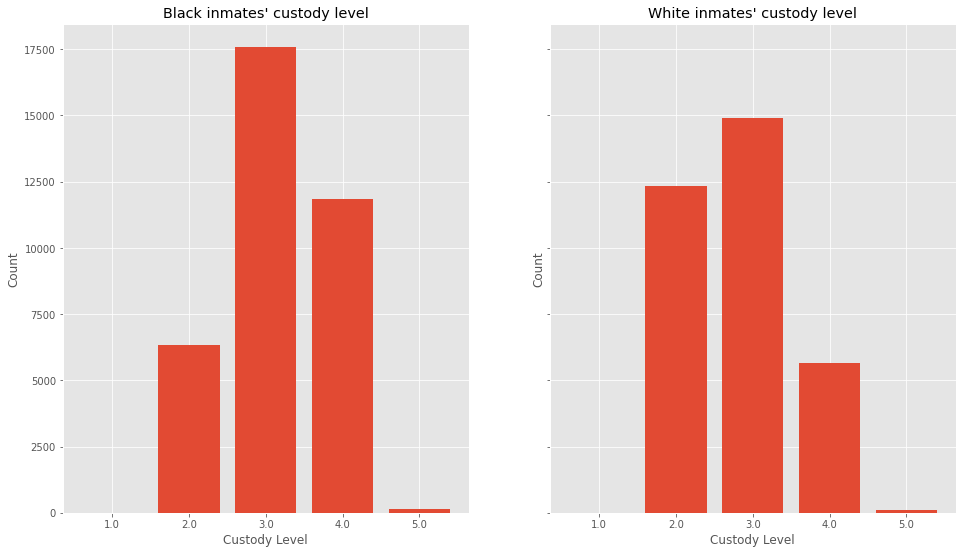

In [14]:
plot_custody_level_by_race(df, False)

In [15]:
data = df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ]
]

In [16]:
data = data.dropna()

In [17]:
len(data)

29622

In [18]:
X = data.drop("custody_level", axis=1)
Y = data["custody_level"]

In [19]:
Y.value_counts(normalize=True)

0    0.646276
1    0.353724
Name: custody_level, dtype: float64

In [20]:
Y.value_counts()

0    19144
1    10478
Name: custody_level, dtype: int64

In [26]:
X_test, X_train, Y_test, Y_train = train_test_split(X, Y, train_size=0.2, random_state=1)

In [27]:
len(X_train), len(X_test)

(23698, 5924)

In [28]:
Y_train.value_counts()

0    15261
1     8437
Name: custody_level, dtype: int64

In [29]:
Y_train.value_counts(normalize=True)

0    0.643978
1    0.356022
Name: custody_level, dtype: float64

In [30]:
Y_test.value_counts()

0    3883
1    2041
Name: custody_level, dtype: int64

In [31]:
model = LogisticRegression(max_iter=10_000)

In [32]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=10000)

In [33]:
coeffs = pd.concat([
    pd.DataFrame(model.intercept_, ["(Intercept)"], columns=["coef"]),
    pd.DataFrame(model.coef_[0], X.columns, columns=['coef']).sort_values(by='coef', ascending=False)
])

In [34]:
coeffs

coef
(Intercept)     -6.326222
escape_hist_5    2.321350
escape_hist_4    1.626415
ic_institut_adj  1.385985
age_lt_25        0.515485
race_A           0.470565
off_1_prs_max    0.281003
race_B           0.231700
race_I           0.209912
off_1_gs_max     0.170022
prior_commits    0.106265
race_O           0.074967
escape_hist_3    0.055640
race_H          -0.228885
escape_hist_2   -0.270279
gender_female   -0.276490
age_gt_45       -0.738915
escape_hist_1   -0.775856
employed        -1.042089
mrt_stat_WID    -1.674515
mrt_stat_MAR    -2.017251
mrt_stat_SEP    -2.207983
mrt_stat_DIV    -2.346500

In [35]:
control = np.exp(model.intercept_[0]) / (1 + np.exp(model.intercept_[0]))

In [36]:
(np.exp(coeffs) / (1 - control + (control * np.exp(coeffs)))).iloc[1:]

coef
escape_hist_5    10.024924
escape_hist_4     5.048778
ic_institut_adj   3.977464
age_lt_25         1.672436
race_A            1.599183
off_1_prs_max     1.323691
race_B            1.260155
race_I            1.233055
off_1_gs_max      1.184938
prior_commits     1.111894
race_O            1.077698
escape_hist_3     1.057109
race_H            0.795711
escape_hist_2     0.763489
gender_female     0.758768
age_gt_45         0.478078
escape_hist_1     0.460754
employed          0.353125
mrt_stat_WID      0.187671
mrt_stat_MAR      0.133227
mrt_stat_SEP      0.110097
mrt_stat_DIV      0.095858

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.909


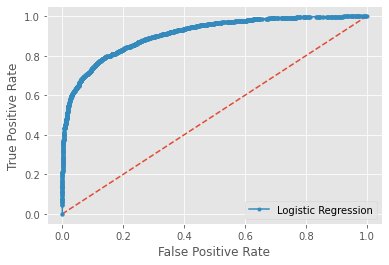

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


ns_probs = [0 for _ in range(len(Y_test))]

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Using statsmodel

In [104]:
import statsmodels.api as sm

In [105]:
logit_model = sm.Logit(Y_train, sm.add_constant(X_train)).fit(method="lbfgs", maxiter=10_000)

In [106]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          custody_level   No. Observations:                 5924
Model:                          Logit   Df Residuals:                     5901
Method:                           MLE   Df Model:                           22
Date:                Sun, 06 Jun 2021   Pseudo R-squ.:                  0.4615
Time:                        21:42:09   Log-Likelihood:                -2054.4
converged:                       True   LL-Null:                       -3815.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.4277      0.304    -21.111      0.000      -7.024      -5.831
gender_female      -0.3569      0.167     -2.132      0.033      -0.685      -0.029
age_gt_45          -0.6816      0.084     -8.089      0.000      -0.847      -0.516
age_lt_25           0.2452      0.334      0.733      0.463      -0.410       0.901
race_B              0.2689      0.092      2.936      0.003       0.089       0.448
race_A              1.1235      0.691      1.626      0.104      -0.231       2.478
race_H             -0.2178      0.136     -1.607      0.108      -0.484       0.048
race_I             -3.8174     10.381     -0.368      0.713     -24.163      16.529
race_O              0.8482      0.669      1.267      0.205      -0.464       2.160
off_1_prs_max       0.3545      0.040      8.770      0.000       0.275       0.434
off_1_gs_max        0.1714      0.014     11.990      0.000       0.143       0.199
prior_commits       0.0932      0.014      6.837      0.000       0.066       0.120
ic_institut_adj     1.3608      0.041     33.224      0.000       1.281       1.441
escape_hist_1      -0.7806      0.180     -4.348      0.000      -1.132      -0.429
escape_hist_2      -0.2359      0.157     -1.498      0.134      -0.545       0.073
escape_hist_3      -0.0555      0.158     -0.351      0.725      -0.365       0.254
escape_hist_4       1.6162      0.205      7.888      0.000       1.215       2.018
escape_hist_5       2.5351      0.299      8.489      0.000       1.950       3.120
mrt_stat_DIV       -2.3320      0.197    -11.865      0.000      -2.717      -1.947
mrt_stat_SEP       -1.9443      0.247     -7.865      0.000      -2.429      -1.460
mrt_stat_MAR       -1.8449      0.150    -12.282      0.000      -2.139      -1.550
mrt_stat_WID       -1.3422      0.406     -3.303      0.001      -2.139      -0.546
employed           -1.0348      0.108     -9.599      0.000      -1.246      -0.823
===================================================================================
"""

In [107]:
logit_model.summary().as_latex()

'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}    &  custody\\_level  & \\textbf{  No. Observations:  } &     5924    \\\\\n\\textbf{Model:}            &      Logit       & \\textbf{  Df Residuals:      } &     5901    \\\\\n\\textbf{Method:}           &       MLE        & \\textbf{  Df Model:          } &       22    \\\\\n\\textbf{Date:}             & Sun, 06 Jun 2021 & \\textbf{  Pseudo R-squ.:     } &   0.4615    \\\\\n\\textbf{Time:}             &     21:42:10     & \\textbf{  Log-Likelihood:    } &   -2054.4   \\\\\n\\textbf{converged:}        &       True       & \\textbf{  LL-Null:           } &   -3815.0   \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{tabular}{lcccccc}\n                           & \\textbf{coef} & \\textbf{std err} & \\textbf{z} & \\textbf{P$> |$z$|$} & \\textbf{[0.025} & \\textbf{0.975]}  \\\\\n\\midrule\n\\textbf{const}             &      -6.4277  &        0.304     &   -21.111  &         0.000        &       -7.024    &       -

In [108]:
for table in logit_model.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &  custody\_level  & \textbf{  No. Observations:  } &    5924   \\
\textbf{Model:}           &      Logit       & \textbf{  Df Residuals:      } &    5901   \\
\textbf{Method:}          &       MLE        & \textbf{  Df Model:          } &      22   \\
\textbf{Date:}            & Sun, 06 Jun 2021 & \textbf{  Pseudo R-squ.:     } &  0.4615   \\
\textbf{Time:}            &     21:42:11     & \textbf{  Log-Likelihood:    } &  -2054.4  \\
\textbf{converged:}       &       True       & \textbf{  LL-Null:           } &  -3815.0  \\
\textbf{Covariance Type:} &    nonrobust     & \textbf{  LLR p-value:       } &   0.000   \\
\bottomrule
\end{tabular}
%\caption{Logit Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lcccccc}
\toprule
                           & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}             &     

In [109]:
ctrl = np.exp(logit_model.params["const"]) / (1 + np.exp(logit_model.params["const"]))

In [110]:
logit_coef = logit_model.params[1:]

In [111]:
logit_coeff_likelyhood = (np.exp(logit_coef) / (1 - ctrl + (ctrl * np.exp(logit_coef))))

array([ 1.33800212,  0.48419132,  1.58938427,  1.26996464,  1.99647344,
        0.79642087,  1.11527522,  1.28532643,  1.34573957,  1.1861396 ,
        1.10952824,  3.9752211 ,  0.46340415,  0.77314201,  1.03872146,
        5.12631988, 10.92611223,  0.09402958,  0.11252466,  0.1365034 ,
        0.18731967,  0.35235567])

In [112]:
print(pd.DataFrame(
    {
        "Variables": logit_coeff_likelyhood.index,
        "Likelyhood": logit_coeff_likelyhood.values
    },
    index=None
).to_latex(index=False))

\begin{tabular}{lr}
\toprule
       Variables &  Likelyhood \\
\midrule
   gender\_female &    0.700158 \\
       age\_gt\_45 &    0.506213 \\
       age\_lt\_25 &    1.277258 \\
          race\_B &    1.307865 \\
          race\_A &    3.065314 \\
          race\_H &    0.804517 \\
          race\_I &    0.022020 \\
          race\_O &    2.330435 \\
   off\_1\_prs\_max &    1.424510 \\
    off\_1\_gs\_max &    1.186627 \\
   prior\_commits &    1.097509 \\
 ic\_institut\_adj &    3.881160 \\
   escape\_hist\_1 &    0.458543 \\
   escape\_hist\_2 &    0.790143 \\
   escape\_hist\_3 &    0.946096 \\
   escape\_hist\_4 &    5.001380 \\
   escape\_hist\_5 &   12.385306 \\
    mrt\_stat\_DIV &    0.097247 \\
    mrt\_stat\_SEP &    0.143290 \\
    mrt\_stat\_MAR &    0.158263 \\
    mrt\_stat\_WID &    0.261574 \\
        employed &    0.355685 \\
\bottomrule
\end{tabular}



In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [54]:
pd.DataFrame(
    {
        'variables':X.columns,
        'VIF':[variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    }
)

variables        VIF
0     gender_female  11.322072
1         age_gt_45   2.751865
2         age_lt_25   1.037310
3            race_B   2.573371
4            race_A   1.007072
5            race_H   1.428210
6            race_I   1.005637
7            race_O   1.010473
8     off_1_prs_max   6.390345
9      off_1_gs_max  12.092882
10    prior_commits   2.387762
11  ic_institut_adj   6.193304
12    escape_hist_1   6.924268
13    escape_hist_2   3.009143
14    escape_hist_3   3.159855
15    escape_hist_4   1.248471
16    escape_hist_5   1.167677
17     mrt_stat_DIV   1.285280
18     mrt_stat_SEP   1.103881
19     mrt_stat_MAR   1.294649
20     mrt_stat_WID   1.036116
21         employed   1.460685

In [55]:
corr = X.corr()

In [128]:
corr.style.background_gradient(cmap="coolwarm")

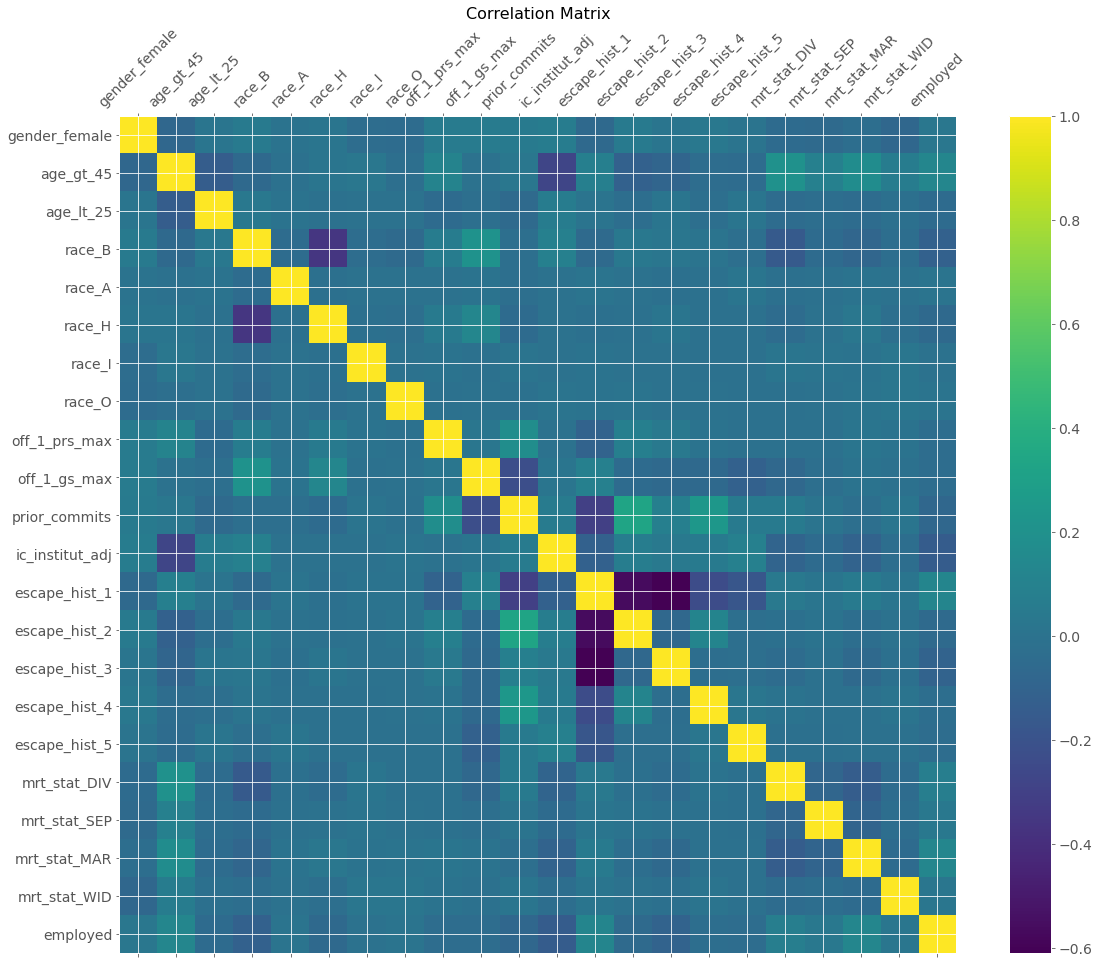

In [58]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [59]:
data = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits"
    ]
]

In [94]:
X = data.drop("custody_level", axis=1)
Y = data["custody_level"]

In [95]:
logit_model = sm.Logit(Y, sm.add_constant(X)).fit(method="lbfgs", maxiter=10_000)

In [96]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          custody_level   No. Observations:                29622
Model:                          Logit   Df Residuals:                    29610
Method:                           MLE   Df Model:                           11
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:                  0.1310
Time:                        18:37:08   Log-Likelihood:                -16724.
converged:                       True   LL-Null:                       -19246.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.3617      0.080    -29.473      0.000      -2.519      -2.205
gender_female     0.3891      0.057      6.856      0.000       0.278       0.500
age_gt_45        -1.4380      0.028    -52.267      0.000      -1.492      -1.384
age_lt_25         0.6979      0.111      6.309      0.000       0.481       0.915
race_B            0.6452      0.030     21.235      0.000       0.586       0.705
race_A            0.8082      0.279      2.898      0.004       0.262       1.355
race_H            0.2681      0.045      5.987      0.000       0.180       0.356
race_I            0.3873      0.370      1.046      0.296      -0.338       1.113
race_O            0.3336      0.241      1.383      0.167      -0.139       0.806
off_1_prs_max     0.1713      0.013     13.150      0.000       0.146       0.197
off_1_gs_max      0.0874      0.005     19.349      0.000       0.079       0.096
prior_commits     0.1171      0.004     26.194      0.000       0.108       0.126
=================================================================================
"""

In [97]:
ctrl = np.exp(logit_model.params["const"]) / (1 + np.exp(logit_model.params["const"]))


In [98]:
logit_coef = logit_model.params[1:]


In [99]:
(np.exp(logit_coef) / (1 - ctrl + (ctrl * np.exp(logit_coef))))

gender_female    1.417511
age_gt_45        0.254102
age_lt_25        1.848708
race_B           1.768376
race_A           2.026722
race_H           1.273686
race_I           1.415331
race_O           1.349942
off_1_prs_max    1.168096
off_1_gs_max     1.082823
prior_commits    1.112369
dtype: float64

In [101]:
model = LogisticRegression(max_iter=10_000)
model.fit(X, Y)


LogisticRegression(max_iter=10000)

No Skill: ROC AUC=0.660
Logistic: ROC AUC=0.743


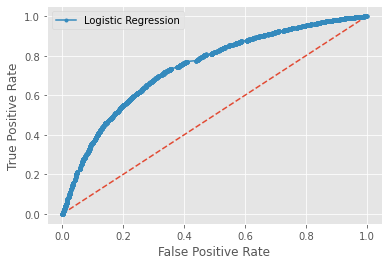

In [104]:
ns_probs = [0 for _ in range(len(Y))]

lr_probs = model.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y, model.predict(X))
lr_auc = roc_auc_score(Y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Checking Assumptions

In [113]:
import scipy.stats as stats

In [115]:
# from: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [116]:
res_df = calculate_residuals(model, X_test, Y_test)

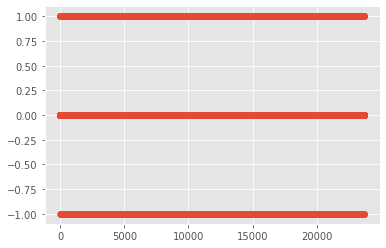

In [117]:
plt.scatter(range(len(res_df.Residuals)), res_df.Residuals)

In [197]:
from heatmap import heatmap

In [203]:
def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(240, 10, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

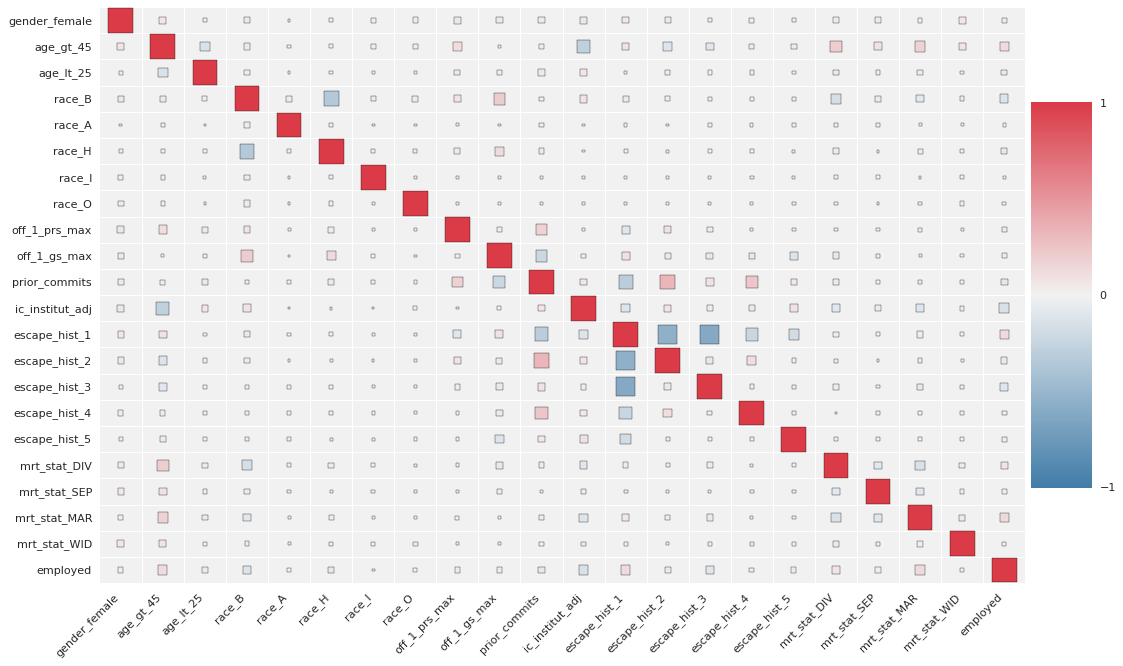

In [208]:
plt.figure(figsize=(16,9))
corrplot(X.corr())

In [1]:
from sklearn import preprocessing

def selected(df):
    df = df.copy()
    df["escaped"] = df["escape_hist_1"] + df["escape_hist_2"] + df["escape_hist_3"] + df["escape_hist_4"] + df["escape_hist_5"]
    enc = preprocessing.LabelEncoder().fit(df.ic_mrtl_stat_fr_cl)
    df["marital_status"] = enc.transform(df.ic_mrtl_stat_fr_cl)
    return df

In [13]:
selected_df = selected(df)

In [15]:
data = selected_df[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escaped",
        "marital_status",
        "employed"
    ]
]

In [16]:
data = data.dropna()

In [17]:
X = data.drop("custody_level", axis=1)
Y = data["custody_level"]

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=1)

In [19]:
model = LogisticRegression(max_iter=10_000)

In [20]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=10000)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.901


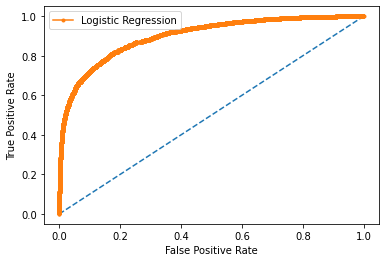

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


ns_probs = [0 for _ in range(len(Y_test))]

lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()